# Image Generation using GANs

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist as mnist

## Data Processing

### Since GANs are unsupervised models we omit the labels.

In [4]:
(train_images, train_labels), (_, _) = mnist.load_data ()

train_images.shape

4422102/4422102 [==============================] - 0s 0us/step


(60000, 28, 28)

In [5]:
BUFFER_SIZE = train_images.shape[0]
IMAGE_DIM = [train_images.shape[1], train_images.shape[2]]
print (BUFFER_SIZE)

60000


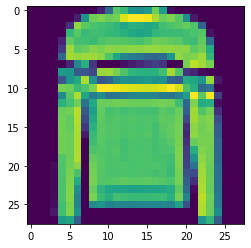

In [6]:
plt.imshow(train_images[5])
plt.show ()

###  Reshape Images to drop the channel count to ONE

In [7]:
NUMBER_OF_CHANNEL = 1

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, NUMBER_OF_CHANNEL).astype('float32')
train_images[0].shape

(28, 28, 1)

### Normalize the data

In [9]:
train_images = (train_images - 127.5) / 127.5

### Batch and Shuffle the data to produce training dataset (Array to Tensorflow Dataset)

In [10]:
#BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Build the Model

### Generator Model

#### Function to create generator model

In [12]:
def get_generator_model (input_shape = 100):

    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model



#### Generator model Instantiation

In [13]:
generator = get_generator_model ()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

#### Generate a sample using the generator 

##### Create random noise

In [14]:
noise = tf.random.normal([1, 100])
noise.shape 

TensorShape([1, 100])

##### Generate Image

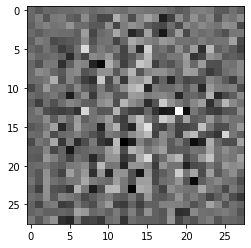

In [15]:
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Although severely distorted the generator does produce image using the noise.

### Discriminator Model

#### Function to create Discriminator Model

In [16]:
def get_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

#### Instantiate the Discriminator model

In [17]:
discriminator = get_discriminator_model ()

discriminator.summary ()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

#### Function to get desicion if the image is fake or not

In [18]:
def get_decision (image, discriminator=discriminator):
  decision = discriminator(generated_image)
  decision = np.array(decision)
  print (decision[0][0])
  if decision < 0.1:
    return "Fake"
  else: return "Real"

#### Check if the generated image is fake or not

In [19]:
get_decision (generated_image)

-0.0010163616


'Fake'

### Configuring the Model

#### Define Loss Function and optimizer for discriminator

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Define Loss function and optimizer for generator

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Create Checkpoints

In [23]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training Model

In [24]:
EPOCHS = 100

num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])


#### Define a Custom Training Step

In [25]:
@tf.function
def  train_step (images):

  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, 
                                               generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                discriminator.trainable_variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      

#### Define the training loop

 In the following method we, 
<ul>
<li>We measure the time for each epoch.</li>
<li> Produce GIFs and Display them.</li>
<li>Save the model after every 5 epochs, as a checkpoint. </li>
<li> Print the Epoch Time. </li>
<li> Generate the Final Image </li>
</ul>

In [26]:
import time
from IPython import display

In [27]:
def train (dataset, epochs):

  for epoch in range(epochs):
    start = time.time ()

    for image_batch in dataset:
      train_step (image_batch)

    display.clear_output(wait=True) 
    generate_and_save_images(generator, epoch + 1, seed)
     
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      
    print (f"Time  taken for epoch {epoch+1} is {start}")

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

##### Function to generate Image

In [28]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#### Train the Model

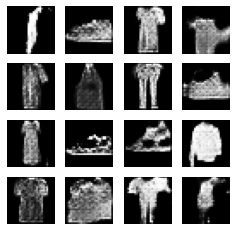

In [29]:
train (train_dataset, EPOCHS)

#### Restore the Model

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### GIF Representing the Evolution of the Images across the EPOCHS

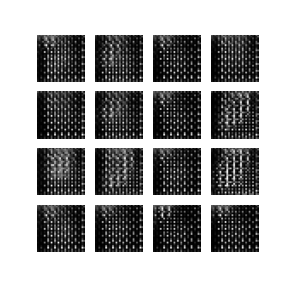

In [31]:
import glob 
import imageio 

anim_file = 'GIF.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  
display.Image(open('GIF.gif','rb').read())

### Try out the generator with Random Noise.

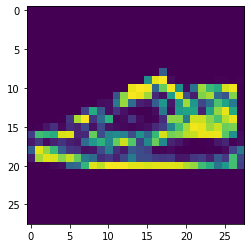

In [50]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])